# Daten importieren
*Datenquelle: [https://www.kaggle.com/datasets/samuelcortinhas/time-series-practice-dataset](https://www.kaggle.com/datasets/samuelcortinhas/time-series-practice-dataset)*

In [2]:
import pandas as pd

df = pd.read_csv("store_product_data_2.csv", parse_dates=["Date"], index_col="Date")
df = df.asfreq('D')
df

,number_sold
Date,
2011-01-02,4580
2011-01-03,4686
2011-01-04,4512
2011-01-05,4658
2011-01-06,4729
...,...
2017-12-26,7355
2017-12-27,7246
2017-12-28,7352


# Daten visualisieren

<Axes: xlabel='Date', ylabel='number_sold'>

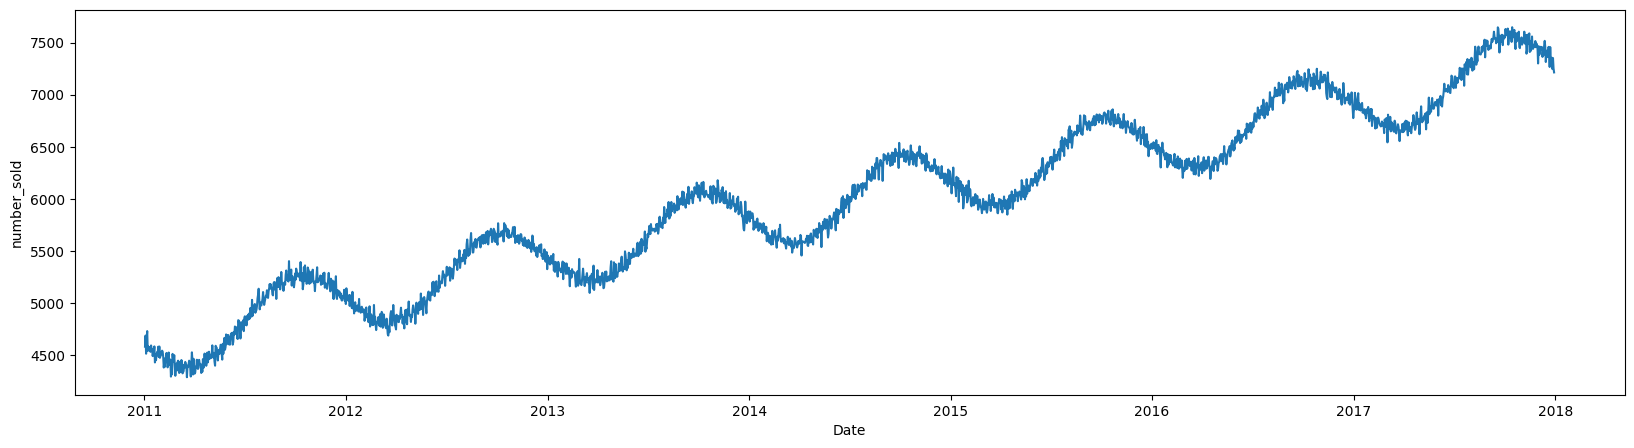

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
sns.lineplot(x=df.index, y=df["number_sold"])

<Axes: xlabel='Date', ylabel='number_sold'>

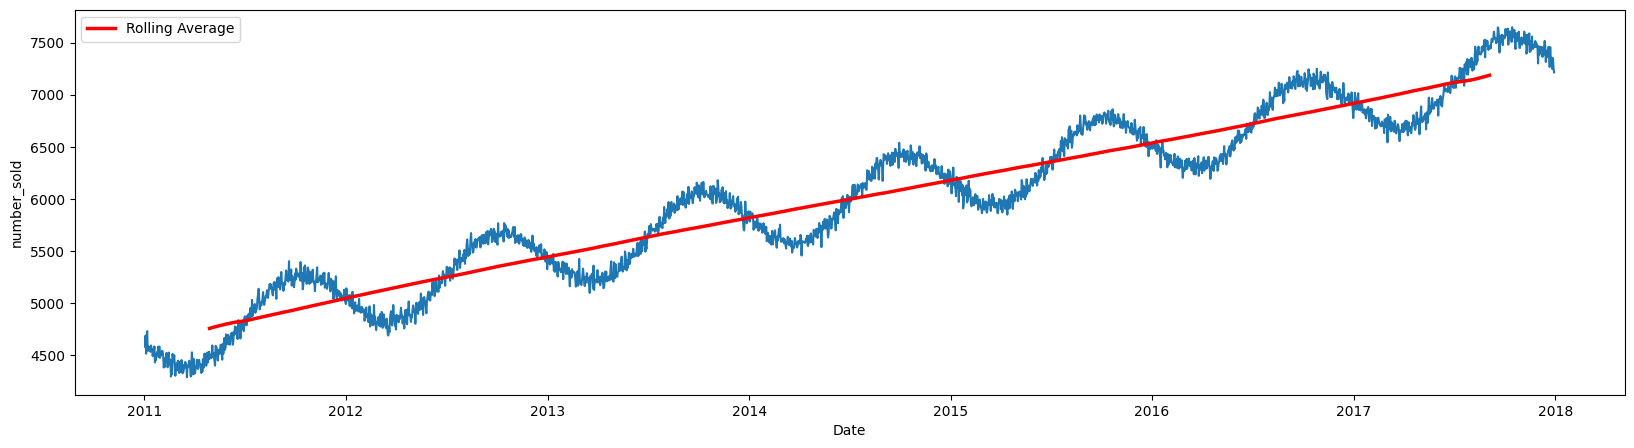

In [4]:
rolling_average_df = df.rolling(window=365, center=True, min_periods=300).mean()

plt.figure(figsize=(20,5))
sns.lineplot(x=df.index, y=df["number_sold"])
sns.lineplot(x=rolling_average_df.index, y=rolling_average_df["number_sold"], color="red", linewidth=2.5, label="Rolling Average")

Text(0.5, 1.0, 'Weekly Plot')

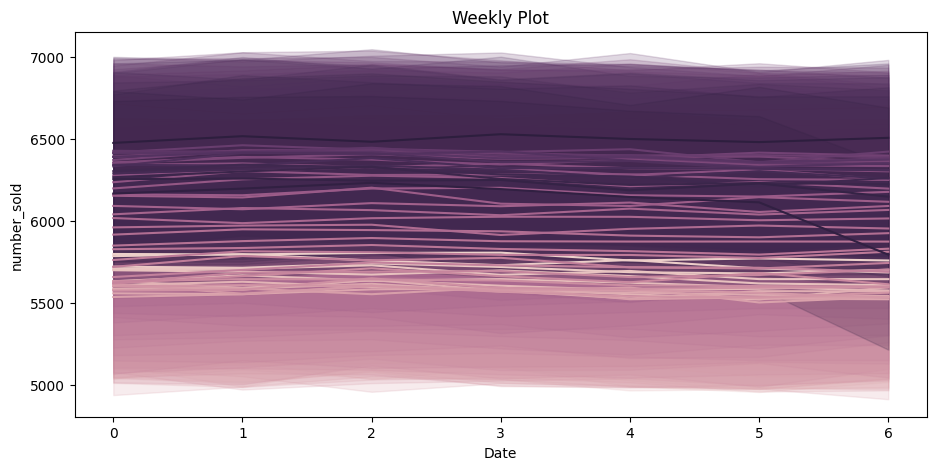

In [5]:
plt.figure(figsize=(11, 5))
sns.lineplot(x=df.index.dayofweek, y=df["number_sold"], hue=df.index.isocalendar().week.astype(int), legend=False)
plt.title("Weekly Plot")

# Daten aufteilen

In [ ]:
df_train = df[df.index.year < 2016]
df_test = df[df.index.year >= 2016]

In [ ]:
df_train

,number_sold
Date,
2011-01-02,4580
2011-01-03,4686
2011-01-04,4512
2011-01-05,4658
2011-01-06,4729
...,...
2015-12-27,6505
2015-12-28,6476
2015-12-29,6517


In [ ]:
df_test

,number_sold
Date,
2016-01-01,6500
2016-01-02,6481
2016-01-03,6507
2016-01-04,6543
2016-01-05,6489
...,...
2017-12-26,7355
2017-12-27,7246
2017-12-28,7352


# Besten Wert für *'order'* bestimmen

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import numpy as np

def best_order_cv(orders, y_train):
    best_order = None
    best_score = float('inf')

    for order in orders:
        fourier = CalendarFourier(freq="Y", order=order)
        dp = DeterministicProcess(index=y_train.index, order=1, additional_terms=[fourier])
        X_train = dp.in_sample()
        model = LinearRegression()
        scores = cross_val_score(model, X_train, y_train, cv=4, scoring="neg_mean_absolute_error")
        mean_score = -np.mean(scores)

        if mean_score < best_score:
            best_order = order
            best_score = mean_score

    return best_order

In [ ]:
result = best_order_cv([1, 2, 3], df_train["number_sold"])
print("The best order is: ", result)

The best order is:  1


# Features generieren

In [ ]:
fourier = CalendarFourier(freq="Y", order=1)
dp = DeterministicProcess(index=df.index, order=1, additional_terms=[fourier])

X = dp.in_sample()
X

,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)"
Date,,,
2011-01-02,1.0,0.017213,0.999852
2011-01-03,2.0,0.034422,0.999407
2011-01-04,3.0,0.051620,0.998667
2011-01-05,4.0,0.068802,0.997630
2011-01-06,5.0,0.085965,0.996298
...,...,...,...
2017-12-26,2551.0,-0.103102,0.994671
2017-12-27,2552.0,-0.085965,0.996298
2017-12-28,2553.0,-0.068802,0.997630


In [ ]:
X_train = X.loc[df_train.index]
X_train

,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)"
Date,,,
2011-01-02,1.0,0.017213,0.999852
2011-01-03,2.0,0.034422,0.999407
2011-01-04,3.0,0.051620,0.998667
2011-01-05,4.0,0.068802,0.997630
2011-01-06,5.0,0.085965,0.996298
...,...,...,...
2015-12-27,1821.0,-0.085965,0.996298
2015-12-28,1822.0,-0.068802,0.997630
2015-12-29,1823.0,-0.051620,0.998667


In [ ]:
y_train = df_train["number_sold"]
y_train

Date
2011-01-02    4580
2011-01-03    4686
2011-01-04    4512
2011-01-05    4658
2011-01-06    4729
              ... 
2015-12-27    6505
2015-12-28    6476
2015-12-29    6517
2015-12-30    6483
2015-12-31    6529
Freq: D, Name: number_sold, Length: 1825, dtype: int64

In [ ]:
X_test = X.loc[df_test.index]
X_test

,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)"
Date,,,
2016-01-01,1826.0,0.000000,1.000000
2016-01-02,1827.0,0.017166,0.999853
2016-01-03,1828.0,0.034328,0.999411
2016-01-04,1829.0,0.051479,0.998674
2016-01-05,1830.0,0.068615,0.997643
...,...,...,...
2017-12-26,2551.0,-0.103102,0.994671
2017-12-27,2552.0,-0.085965,0.996298
2017-12-28,2553.0,-0.068802,0.997630


In [ ]:
y_test = df_test["number_sold"]
y_test

Date
2016-01-01    6500
2016-01-02    6481
2016-01-03    6507
2016-01-04    6543
2016-01-05    6489
              ... 
2017-12-26    7355
2017-12-27    7246
2017-12-28    7352
2017-12-29    7253
2017-12-30    7214
Freq: D, Name: number_sold, Length: 730, dtype: int64

# Modell trainieren

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Modell visualisieren

In [ ]:
train_predictions = model.predict(X_train)

<Axes: xlabel='Date', ylabel='number_sold'>

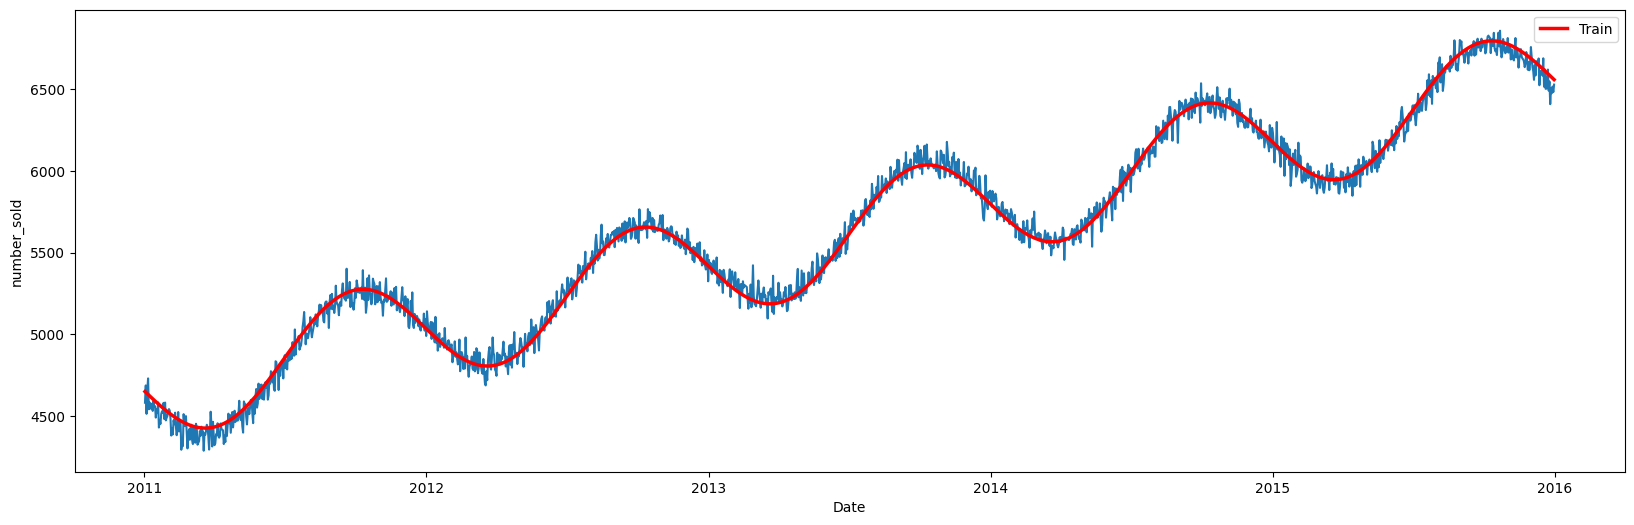

In [ ]:
plt.figure(figsize=(20, 6))
sns.lineplot(x=X_train.index, y=y_train)
sns.lineplot(x=X_train.index, y=train_predictions, color="red", linewidth=2.5, label="Train")

# Vorhersage auf den Testdaten

In [ ]:
X_test

,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)"
Date,,,
2016-01-01,1826.0,0.000000,1.000000
2016-01-02,1827.0,0.017166,0.999853
2016-01-03,1828.0,0.034328,0.999411
2016-01-04,1829.0,0.051479,0.998674
2016-01-05,1830.0,0.068615,0.997643
...,...,...,...
2017-12-26,2551.0,-0.103102,0.994671
2017-12-27,2552.0,-0.085965,0.996298
2017-12-28,2553.0,-0.068802,0.997630


In [ ]:
test_predictions = model.predict(X_test)

# Modellbewertung (Mean Absolute Error)

In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test_predictions, y_test)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 45.40673384537375


<Axes: xlabel='Date', ylabel='number_sold'>

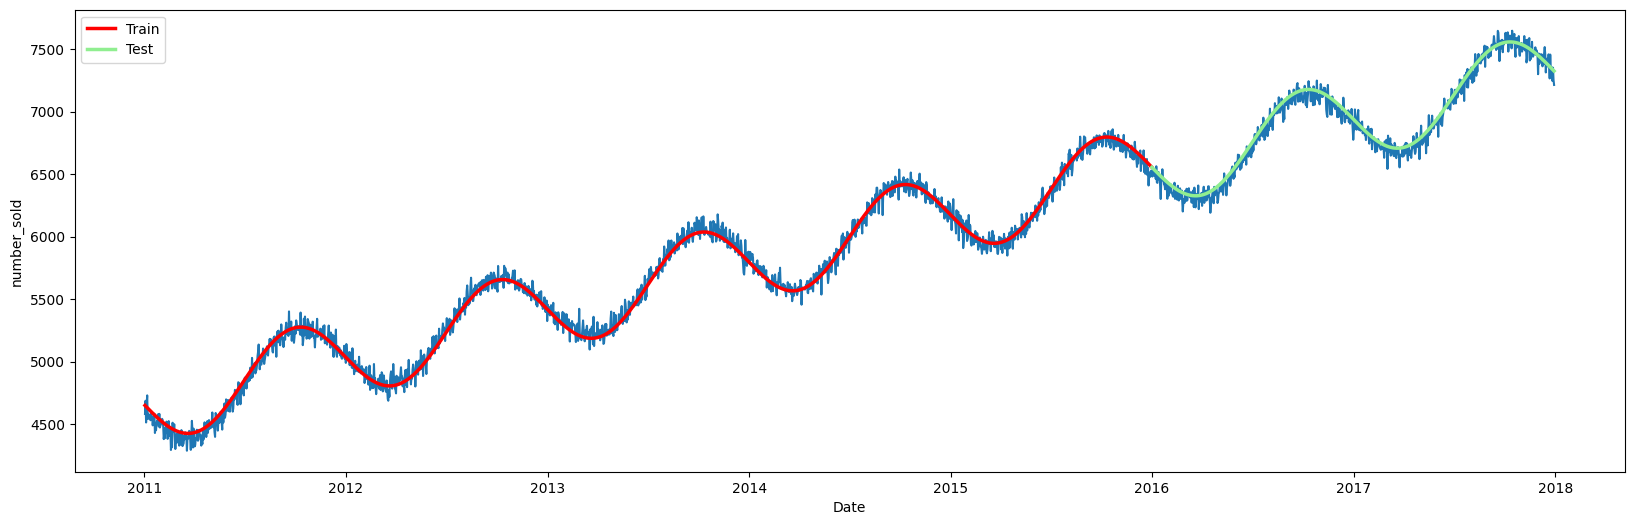

In [ ]:
plt.figure(figsize=(20, 6))
sns.lineplot(x=df.index, y=df["number_sold"])
sns.lineplot(x=X_train.index, y=train_predictions, color="red", linewidth=2.5, label="Train")
sns.lineplot(x=X_test.index, y=test_predictions, color="lightgreen", linewidth=2.5, label="Test")

# Prognosen für das nächste Jahr:

In [ ]:
X_forecast = dp.out_of_sample(steps=365)
X_forecast

,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)"
2017-12-31,2556.0,-0.017213,0.999852
2018-01-01,2557.0,0.000000,1.000000
2018-01-02,2558.0,0.017213,0.999852
2018-01-03,2559.0,0.034422,0.999407
2018-01-04,2560.0,0.051620,0.998667
...,...,...,...
2018-12-26,2916.0,-0.103102,0.994671
2018-12-27,2917.0,-0.085965,0.996298
2018-12-28,2918.0,-0.068802,0.997630
2018-12-29,2919.0,-0.051620,0.998667


In [ ]:
forecast_predictions = model.predict(X_forecast)

<Axes: xlabel='Date', ylabel='number_sold'>

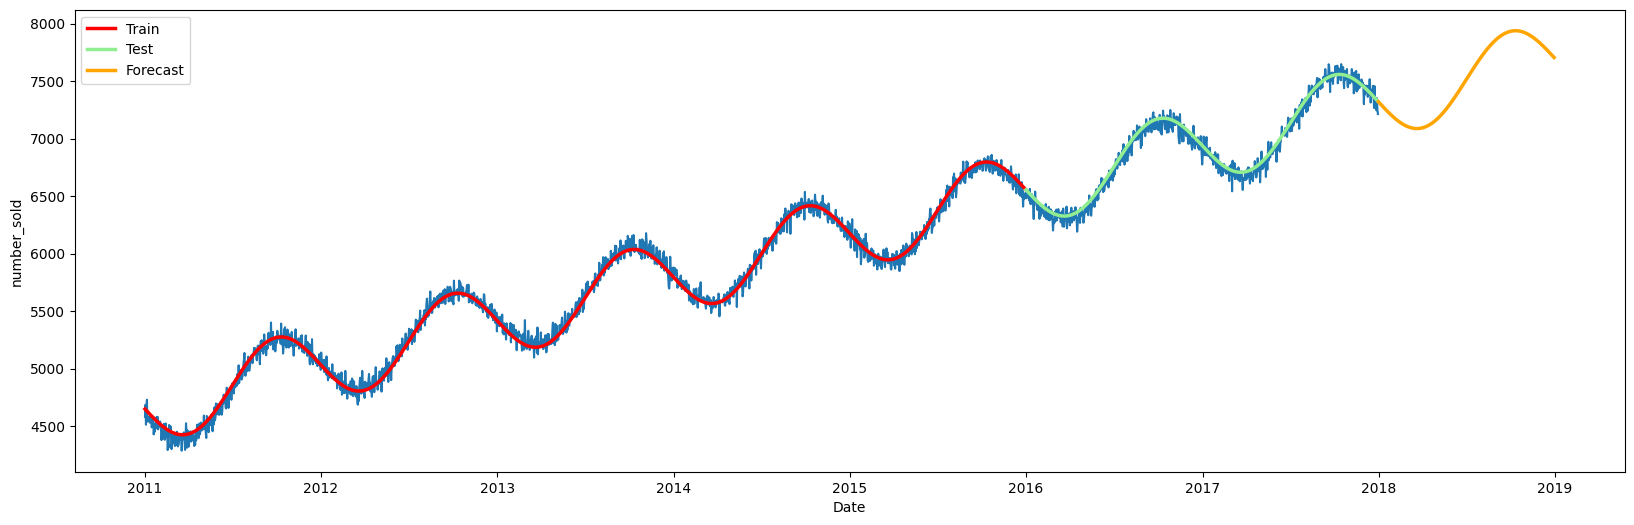

In [ ]:
plt.figure(figsize=(20, 6))
sns.lineplot(x=df.index, y=df["number_sold"])
sns.lineplot(x=X_train.index, y=train_predictions, color="red", linewidth=2.5, label="Train")
sns.lineplot(x=X_test.index, y=test_predictions, color="lightgreen", linewidth=2.5, label="Test")
sns.lineplot(x=X_forecast.index, y=forecast_predictions, color="orange", linewidth=2.5, label="Forecast")